In [78]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier, Pool, cv, EFstrType

from sklearn.model_selection import cross_val_score, train_test_split

from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, balanced_accuracy_score
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score
from sklearn.metrics import brier_score_loss, log_loss

from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import random
import os
import pickle

import embiggen

import datetime

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.calibration import CalibratedClassifierCV
from sklearn.isotonic import IsotonicRegression

import shap

current_datetime = datetime.datetime.now()
formatted_date = current_datetime.strftime("%Y-%m-%d_%H_%M_%S")
print(formatted_date)

2025-02-13_22_34_14


In [79]:
RANDOM_SEED = 12
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

random_seed = random.seed
#print(random.seed)
#print(np.random.get_state())

In [80]:
modellabel = "temperature__EC_RHEA_v5"

In [2]:
#Download the nodes and edges files from this url (corresponding to the manuscript KG release):
#https://github.com/Knowledge-Graph-Hub/kg-microbe/releases/download/2025-03-07/kg-microbe-core.tar.gz
#
#Then extract it and update the path in the pd.read_csv() below:
#tar -xvzf kg-microbe-core.tar.gz

#data = pd.read_csv("merged-kg_edges.tsv", header=0, sep="\t")

In [3]:
#nodes already downloaded in previous step

#data_nodes = pd.read_csv("merged-kg_nodes.tsv", header=0, sep="\t")

In [83]:
data_nodes

,id,category,name,description,xref,provided_by,synonym,deprecated,iri,object,predicate,relation,same_as,subject,subsets
0,EC:4.1.99.1,biolink:Enzyme|biolink:PhenotypicQuality,tryptophan deaminase,NaN,NaN,Graph,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CHEBI:16828,biolink:ChemicalEntity|biolink:ChemicalSubstance,L-tryptophan,The L-enantiomer of tryptophan.,CAS-RN:73-22-3|DrugBank:DB00150|Drug_Central:2...,Graph,(2S)-2-amino-3-(1H-indol-3-yl)propanoic acid|(...,NaN,http://purl.obolibrary.org/obo/CHEBI_16828,NaN,NaN,NaN,NaN,NaN,3_STAR
2,EC:3.5.1.5,biolink:Enzyme|biolink:PhenotypicQuality,urease,NaN,NaN,Graph,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,CHEBI:16199,biolink:ChemicalEntity|biolink:ChemicalSubstance,Urea,A carbonyl group with two C-bound amine groups...,CAS-RN:57-13-6|DrugBank:DB03904|Drug_Central:4...,Graph,1728|Carbamide|E927b|H2NC(O)NH2|Harnstoff|Karb...,NaN,http://purl.obolibrary.org/obo/CHEBI_16199|htt...,NaN,NaN,NaN,NaN,NaN,3_STAR
4,CHEBI:17634,biolink:ChemicalEntity|biolink:ChemicalSubstance,(-)-D-glucose,A glucose with D-configuration.,CAS-RN:50-99-7,Graph,D(+)-glucose|D-(+)-glucose|D-gluco-hexose|D-gl...,NaN,http://purl.obolibrary.org/obo/CHEBI_17634,NaN,NaN,NaN,NaN,NaN,3_STAR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1623188,pigment:orange,biolink:ChemicalSubstance,orange pigment,NaN,NaN,Graph,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1623189,pigment:white,biolink:ChemicalSubstance,white pigment,NaN,NaN,Graph,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1623190,trophic_type:copiotroph_diazotrophy,biolink:BiologicalProcess,copiotroph diazotroph,NaN,NaN,Graph,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1623191,pigment:green,biolink:ChemicalSubstance,green pigment,NaN,NaN,Graph,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [84]:
data_pairs = data[['subject','object']].drop_duplicates()
data_pairs

,subject,object
0,EC:4.1.99.1,assay:API_20A_IND
1,EC:4.1.99.1,assay:API_20NE_TRP
2,EC:4.1.99.1,assay:API_20E_IND
3,EC:4.1.99.1,assay:API_NH_IND
4,EC:4.1.99.1,assay:API_ID32E_IND
...,...,...
3211061,cell_shape:star_dumbbell_pleomorphic,cell_shape:pleomorphic
3211062,cell_shape:curved_spiral,cell_shape:curved
3211063,cell_shape:curved_spiral,cell_shape:spiral
3211064,trophic_type:copiotroph_diazotrophy,trophic_type:copiotrophy


In [85]:
# Subset the DataFrame based on the substring in subject
data_pairs_clean = data_pairs[data_pairs['subject'].str.contains('NCBITaxon:|strain:')]
# Subset the DataFrame based on the substring in object
data_pairs_clean = data_pairs_clean[data_pairs_clean['object'].str.contains('temperature')]
data_pairs_clean.to_csv("NCBITaxon_to_temperature_v2.tsv", sep="\t", header=True, index=False)
data_pairs_clean.shape

(30244, 2)

In [86]:
#TODO add closure

data_pairs_chem = data_pairs[data_pairs['subject'].str.contains('NCBITaxon:|strain:')]
data_pairs_chem = data_pairs_chem[data_pairs_chem['object'].str.contains('CHEBI:')]
data_pairs_chem.shape

(276638, 2)

In [87]:
#TODO add closure
###
### ESPECIALLY for Taxonomy subClassOf >> one hot
###

data_pairs_go = data_pairs[data_pairs['subject'].str.contains('NCBITaxon:|strain:')]
data_pairs_go = data_pairs_go[data_pairs_go['object'].str.contains('GO:')]
data_pairs_go.shape

(0, 2)

#RELEVANT predicates

50357 biolink:assesses

126997 biolink:capable_of

127784 biolink:consumes

150279 biolink:has_phenotype

26755 biolink:location_of

32513 biolink:occurs_in

3692 biolink:produces

570848 biolink:related_to

830076 biolink:subclass_of

In [88]:
data_pairs_rest_all = data_pairs[data_pairs['subject'].str.contains('NCBITaxon:|strain:')]
data_pairs_rest = data_pairs_rest_all[data_pairs_rest_all['object'].str.contains('carbon_substrates:')]
data_pairs_rest2 = data_pairs_rest_all[data_pairs_rest_all['object'].str.contains('pathways:')]
data_pairs_rest = pd.concat([data_pairs_rest, data_pairs_rest2], ignore_index=True)
data_pairs_rest2 = data_pairs_rest_all[data_pairs_rest_all['object'].str.contains('trophic_type:')]
data_pairs_rest = pd.concat([data_pairs_rest, data_pairs_rest2], ignore_index=True)
data_pairs_rest2 = data_pairs_rest_all[data_pairs_rest_all['object'].str.contains('production:')]
data_pairs_rest = pd.concat([data_pairs_rest, data_pairs_rest2], ignore_index=True)
data_pairs_rest2 = data_pairs_rest_all[data_pairs_rest_all['object'].str.contains('CAS-RN:')]
data_pairs_rest = pd.concat([data_pairs_rest, data_pairs_rest2], ignore_index=True)
data_pairs_rest2 = data_pairs_rest_all[data_pairs_rest_all['object'].str.contains('CHEBI:')]
data_pairs_rest = pd.concat([data_pairs_rest, data_pairs_rest2], ignore_index=True)
data_pairs_rest2 = data_pairs_rest_all[data_pairs_rest_all['object'].str.contains('EC:')]
data_pairs_rest = pd.concat([data_pairs_rest, data_pairs_rest2], ignore_index=True)
data_pairs_rest2 = data_pairs_rest_all[data_pairs_rest_all['object'].str.contains('GO:')]
data_pairs_rest = pd.concat([data_pairs_rest, data_pairs_rest2], ignore_index=True)

data_pairs_rest2 = data_pairs_rest_all[data_pairs_rest_all['object'].str.contains('cell_shape:')]
data_pairs_rest = pd.concat([data_pairs_rest, data_pairs_rest2], ignore_index=True)
data_pairs_rest2 = data_pairs_rest_all[data_pairs_rest_all['object'].str.contains('cell_length:')]
data_pairs_rest = pd.concat([data_pairs_rest, data_pairs_rest2], ignore_index=True)
data_pairs_rest2 = data_pairs_rest_all[data_pairs_rest_all['object'].str.contains('cell_width:')]
data_pairs_rest = pd.concat([data_pairs_rest, data_pairs_rest2], ignore_index=True)
data_pairs_rest2 = data_pairs_rest_all[data_pairs_rest_all['object'].str.contains('motility:')]
data_pairs_rest = pd.concat([data_pairs_rest, data_pairs_rest2], ignore_index=True)
data_pairs_rest2 = data_pairs_rest_all[data_pairs_rest_all['object'].str.contains('sporulation:')]
data_pairs_rest = pd.concat([data_pairs_rest, data_pairs_rest2], ignore_index=True)
data_pairs_rest2 = data_pairs_rest_all[data_pairs_rest_all['object'].str.contains('pigment:')]
data_pairs_rest = pd.concat([data_pairs_rest, data_pairs_rest2], ignore_index=True)
data_pairs_rest2 = data_pairs_rest_all[data_pairs_rest_all['object'].str.contains('gram_stain:')]
data_pairs_rest = pd.concat([data_pairs_rest, data_pairs_rest2], ignore_index=True)

data_pairs_rest2 = data_pairs_rest_all[data_pairs_rest_all['object'].str.contains('gc:')]
data_pairs_rest = pd.concat([data_pairs_rest, data_pairs_rest2], ignore_index=True)

data_pairs_rest2 = data_pairs_rest_all[data_pairs_rest_all['object'].str.contains('pH_.*:')]
data_pairs_rest = pd.concat([data_pairs_rest, data_pairs_rest2], ignore_index=True)
data_pairs_rest2 = data_pairs_rest_all[data_pairs_rest_all['object'].str.contains('temp_.*:')]
data_pairs_rest = pd.concat([data_pairs_rest, data_pairs_rest2], ignore_index=True)
data_pairs_rest2 = data_pairs_rest_all[data_pairs_rest_all['object'].str.contains('temperature:')]
data_pairs_rest = pd.concat([data_pairs_rest, data_pairs_rest2], ignore_index=True)
data_pairs_rest2 = data_pairs_rest_all[data_pairs_rest_all['object'].str.contains('salinity:')]
data_pairs_rest = pd.concat([data_pairs_rest, data_pairs_rest2], ignore_index=True)
data_pairs_rest2 = data_pairs_rest_all[data_pairs_rest_all['object'].str.contains('NaCl_.*:')]
data_pairs_rest = pd.concat([data_pairs_rest, data_pairs_rest2], ignore_index=True)
data_pairs_rest2 = data_pairs_rest_all[data_pairs_rest_all['object'].str.contains('oxygen:')]
data_pairs_rest = pd.concat([data_pairs_rest, data_pairs_rest2], ignore_index=True)

data_pairs_rest2 = data_pairs_rest_all[data_pairs_rest_all['object'].str.contains('pathogen:')]
data_pairs_rest = pd.concat([data_pairs_rest, data_pairs_rest2], ignore_index=True)
data_pairs_rest2 = data_pairs_rest_all[data_pairs_rest_all['object'].str.contains('isolation_source:')]
data_pairs_rest = pd.concat([data_pairs_rest, data_pairs_rest2], ignore_index=True)
data_pairs_rest2 = data_pairs_rest_all[data_pairs_rest_all['object'].str.contains('ENVO:')]
data_pairs_rest = pd.concat([data_pairs_rest, data_pairs_rest2], ignore_index=True)
data_pairs_rest2 = data_pairs_rest_all[data_pairs_rest_all['object'].str.contains('UBERON:')]
data_pairs_rest = pd.concat([data_pairs_rest, data_pairs_rest2], ignore_index=True)
data_pairs_rest2 = data_pairs_rest_all[data_pairs_rest_all['object'].str.contains('PO:')]
data_pairs_rest = pd.concat([data_pairs_rest, data_pairs_rest2], ignore_index=True)

In [89]:
data_pairs_rest_all2 = data_pairs[data_pairs['object'].str.contains('NCBITaxon:|strain:')]
# Swap 'subject' and 'object' for the filtered DataFrame
data_pairs_rest_all2_swapped = data_pairs_rest_all2.copy()
data_pairs_rest_all2_swapped['subject'], data_pairs_rest_all2_swapped['object'] = data_pairs_rest_all2['object'], data_pairs_rest_all2['subject']
data_pairs_rest2 = data_pairs_rest_all2_swapped[data_pairs_rest_all2_swapped['object'].str.contains('PATO:')]
data_pairs_rest = pd.concat([data_pairs_rest, data_pairs_rest2], ignore_index=True)
data_pairs_rest2 = data_pairs_rest_all2_swapped[data_pairs_rest_all2_swapped['object'].str.contains('UBERON:')]
data_pairs_rest = pd.concat([data_pairs_rest, data_pairs_rest2], ignore_index=True)
data_pairs_rest2 = data_pairs_rest_all2_swapped[data_pairs_rest_all2_swapped['object'].str.contains('FOODON:')]
data_pairs_rest = pd.concat([data_pairs_rest, data_pairs_rest2], ignore_index=True)
data_pairs_rest2 = data_pairs_rest_all2_swapped[data_pairs_rest_all2_swapped['object'].str.contains('CHEBI:')]
data_pairs_rest = pd.concat([data_pairs_rest, data_pairs_rest2], ignore_index=True)
data_pairs_rest2 = data_pairs_rest_all2_swapped[data_pairs_rest_all2_swapped['object'].str.contains('ENVO:')]
data_pairs_rest = pd.concat([data_pairs_rest, data_pairs_rest2], ignore_index=True)
data_pairs_rest2 = data_pairs_rest_all2_swapped[data_pairs_rest_all2_swapped['object'].str.contains('PO:')]
data_pairs_rest = pd.concat([data_pairs_rest, data_pairs_rest2], ignore_index=True)
data_pairs_rest2 = data_pairs_rest_all2_swapped[data_pairs_rest_all2_swapped['object'].str.contains('assay:')]
data_pairs_rest = pd.concat([data_pairs_rest, data_pairs_rest2], ignore_index=True)
data_pairs_rest.shape

(727479, 2)

In [90]:
%time
#data_df_pairs = pd.concat([data_pairs_chem, data_pairs_go], ignore_index=True)
#data_df_pairs = pd.concat([data_df_pairs, data_pairs_rest], ignore_index=True)

data_pairs_rest['Value'] = 1

# Step 2: Pivot the old DataFrame to form the new DataFrame structure
data_df = data_pairs_rest.pivot_table(index='subject', columns='object', values='Value', aggfunc='sum', fill_value=0)
# Step 3: Fill NaN values with 0 to indicate no relationship
#data_df = data_df.fillna(0)

# Optionally, convert the filled NaN values to integers if they were floats after pivot
data_df = data_df.astype(int)
data_df

CPU times: user 1 µs, sys: 1e+03 ns, total: 2 µs
Wall time: 3.1 µs


object,CHEBI:100147,CHEBI:10024,CHEBI:100241,CHEBI:100246,CHEBI:10057,CHEBI:102130,CHEBI:102484,CHEBI:115156,CHEBI:116278,CHEBI:11986,...,trophic_type:mixotrophy,trophic_type:oligotrophy,trophic_type:organoheterotrophy,trophic_type:organotrophy,trophic_type:photoautotrophy,trophic_type:photoheterotrophy,trophic_type:photolithoautotrophy,trophic_type:photolithotrophy,trophic_type:photoorganoheterotrophy,trophic_type:phototrophy
subject,,,,,,,,,,,,,,,,,,,,,
NCBITaxon:100,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NCBITaxon:100053,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NCBITaxon:1000560,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NCBITaxon:1000561,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NCBITaxon:1000562,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
strain:bacdive_97,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
strain:bacdive_98,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
strain:bacdive_9804,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [91]:
%%time
# Filter these IDs from data_pairs_clean
data_pairs_clean_filtered = data_pairs_clean.copy(deep=True)

# Group by 'subject' and list all 'object' (temperature)
#taxon_temperature_groups = data_pairs_clean_filtered.groupby('subject')['object'].agg(list)
taxon_temperature_groups = data_pairs_clean_filtered[data_pairs_clean_filtered['object'].str.startswith('temperature:')].groupby('subject')['object'].agg(list)

print(taxon_temperature_groups)

# Filter taxons with a single and multiple temperature associations
single_temperature_taxons = taxon_temperature_groups[taxon_temperature_groups.apply(len) == 1].apply(lambda x: x[0])
multiple_temperature_taxons = taxon_temperature_groups[taxon_temperature_groups.apply(len) > 1]

print(f"single O2 {single_temperature_taxons} mult {multiple_temperature_taxons}")

# Create DataFrame for single temperature counts
single_temperature_counts = data_pairs_clean_filtered[data_pairs_clean_filtered['object'].isin(single_temperature_taxons)].groupby('object').size()

# Get the most common temperature from single associations
sorted_single_temperature_counts = single_temperature_counts.sort_values(ascending=False)
if len(sorted_single_temperature_counts) > 0:
    second_most_common_temperature = sorted_single_temperature_counts.index[0]  # Second most common temperature
else:
    second_most_common_temperature = None  # Handle cases with less than two temperature types

# Function to filter for the most common temperature within their available list
def filter_most_common(temperature_list):
    # Filter temperature list to include only those in single_temperature_counts, then sort based on counts
    temperature_list_list_counts = {temperature: single_temperature_counts.get(temperature, 0) for temperature in temperature_list if temperature in single_temperature_counts}
    sorted_temperature_list_list = sorted(temperature_list_list_counts.items(), key=lambda item: item[1], reverse=True)
    if len(sorted_temperature_list_list) > 0:
        return sorted_temperature_list_list[0][0]  # Return the X most common
    return None

# Apply the filter function
multiple_temperature_taxons = multiple_temperature_taxons.apply(filter_most_common)
multiple_temperature_taxons = multiple_temperature_taxons.dropna()

# Combine single temperature taxons with adjusted multiple temperature taxons
final_taxons = pd.concat([single_temperature_taxons, multiple_temperature_taxons])

# Reset index and prepare the final DataFrame
final_df = final_taxons.reset_index()
final_df.columns = ['subject', 'Mapped_temperature']
final_df['SingleOrMultiple'] = ['single' if len(taxon_temperature_groups[x]) == 1 else 'multiple' for x in final_df['subject']]

# Rename 'subject' column to 'NCBITaxon' in final_df
final_df.rename(columns={'subject': 'NCBITaxon'}, inplace=True)
final_df.rename(columns={'Mapped_temperature': 'temperature'}, inplace=True)
final_df.index = final_df['NCBITaxon']
final_df = final_df.drop(columns=['NCBITaxon'])
final_df = final_df.drop(columns=['SingleOrMultiple'])

# Export to CSV
final_df.to_csv('taxa_temperature_mapping_adjusted_v2.tsv', index=True, sep="\t")
final_df

subject
NCBITaxon:100          [temperature:mesophilic]
NCBITaxon:100053       [temperature:mesophilic]
NCBITaxon:1000562      [temperature:mesophilic]
NCBITaxon:1000566      [temperature:mesophilic]
NCBITaxon:1001         [temperature:mesophilic]
                                 ...           
strain:bacdive_97      [temperature:mesophilic]
strain:bacdive_98      [temperature:mesophilic]
strain:bacdive_9804    [temperature:mesophilic]
strain:bacdive_99      [temperature:mesophilic]
strain:bacdive_9984    [temperature:mesophilic]
Name: object, Length: 30003, dtype: object
single O2 subject
NCBITaxon:100          temperature:mesophilic
NCBITaxon:100053       temperature:mesophilic
NCBITaxon:1000562      temperature:mesophilic
NCBITaxon:1000566      temperature:mesophilic
NCBITaxon:1001         temperature:mesophilic
                                ...          
strain:bacdive_97      temperature:mesophilic
strain:bacdive_98      temperature:mesophilic
strain:bacdive_9804    temperature:

,temperature
NCBITaxon,
NCBITaxon:100,temperature:mesophilic
NCBITaxon:100053,temperature:mesophilic
NCBITaxon:1000562,temperature:mesophilic
NCBITaxon:1000566,temperature:mesophilic
NCBITaxon:1001,temperature:mesophilic
...,...
NCBITaxon:882211,temperature:mesophilic
NCBITaxon:895,temperature:mesophilic
NCBITaxon:906888,temperature:mesophilic


In [92]:
final_df['temperature'].value_counts().sum()

30003

In [93]:
print("Columns in data_df:", data_df.columns)
print("Columns in final_df:", final_df.columns)
print("Rows in data_df:", data_df.index)
print("Rows in final_df:", final_df.index)

Columns in data_df: Index(['CHEBI:100147', 'CHEBI:10024', 'CHEBI:100241', 'CHEBI:100246',
       'CHEBI:10057', 'CHEBI:102130', 'CHEBI:102484', 'CHEBI:115156',
       'CHEBI:116278', 'CHEBI:11986',
       ...
       'trophic_type:mixotrophy', 'trophic_type:oligotrophy',
       'trophic_type:organoheterotrophy', 'trophic_type:organotrophy',
       'trophic_type:photoautotrophy', 'trophic_type:photoheterotrophy',
       'trophic_type:photolithoautotrophy', 'trophic_type:photolithotrophy',
       'trophic_type:photoorganoheterotrophy', 'trophic_type:phototrophy'],
      dtype='object', name='object', length=1773)
Columns in final_df: Index(['temperature'], dtype='object')
Rows in data_df: Index(['NCBITaxon:100', 'NCBITaxon:100053', 'NCBITaxon:1000560',
       'NCBITaxon:1000561', 'NCBITaxon:1000562', 'NCBITaxon:1000565',
       'NCBITaxon:1000566', 'NCBITaxon:1000567', 'NCBITaxon:1000568',
       'NCBITaxon:1000569',
       ...
       'strain:bacdive_94', 'strain:bacdive_9436', 'strain:ba

In [94]:
data_df = data_df.merge(final_df, left_index=True, right_index=True, how='left')
data_df

,CHEBI:100147,CHEBI:10024,CHEBI:100241,CHEBI:100246,CHEBI:10057,CHEBI:102130,CHEBI:102484,CHEBI:115156,CHEBI:116278,CHEBI:11986,...,trophic_type:oligotrophy,trophic_type:organoheterotrophy,trophic_type:organotrophy,trophic_type:photoautotrophy,trophic_type:photoheterotrophy,trophic_type:photolithoautotrophy,trophic_type:photolithotrophy,trophic_type:photoorganoheterotrophy,trophic_type:phototrophy,temperature
subject,,,,,,,,,,,,,,,,,,,,,
NCBITaxon:100,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,temperature:mesophilic
NCBITaxon:100053,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,temperature:mesophilic
NCBITaxon:1000560,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
NCBITaxon:1000561,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
NCBITaxon:1000562,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,temperature:mesophilic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
strain:bacdive_97,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,temperature:mesophilic
strain:bacdive_98,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,temperature:mesophilic
strain:bacdive_9804,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,temperature:mesophilic


In [95]:
data_df.columns

Index(['CHEBI:100147', 'CHEBI:10024', 'CHEBI:100241', 'CHEBI:100246',
       'CHEBI:10057', 'CHEBI:102130', 'CHEBI:102484', 'CHEBI:115156',
       'CHEBI:116278', 'CHEBI:11986',
       ...
       'trophic_type:oligotrophy', 'trophic_type:organoheterotrophy',
       'trophic_type:organotrophy', 'trophic_type:photoautotrophy',
       'trophic_type:photoheterotrophy', 'trophic_type:photolithoautotrophy',
       'trophic_type:photolithotrophy', 'trophic_type:photoorganoheterotrophy',
       'trophic_type:phototrophy', 'temperature'],
      dtype='object', length=1774)

In [96]:

data_df['temperature'].value_counts().sum()

30003

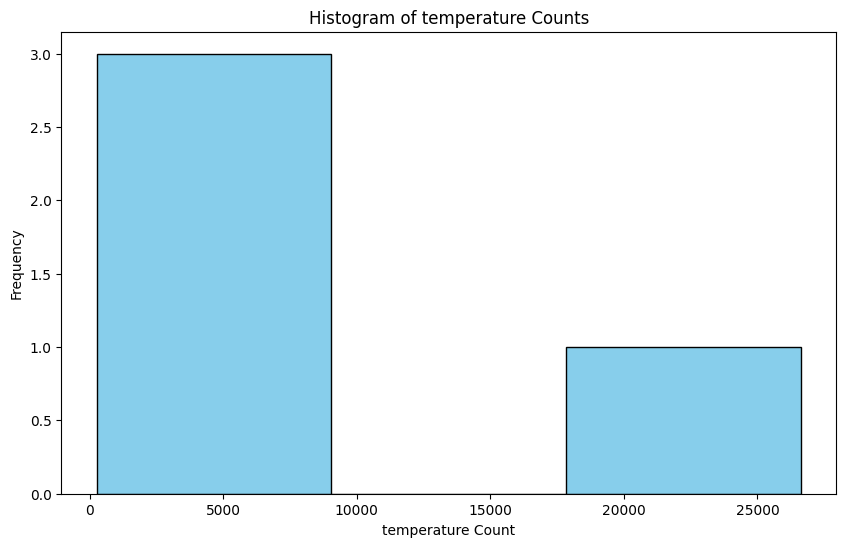

In [97]:
# Assuming data_pairs_clean_filtered['temperatureCount'] exists and is populated with the occurrence counts of each temperature
plt.figure(figsize=(10, 6))  # Optional: Adjusts the size of the plot
plt.hist(data_df['temperature'].value_counts(), bins='auto', color='skyblue', edgecolor='black')
plt.title('Histogram of temperature Counts')
plt.xlabel('temperature Count')
plt.ylabel('Frequency')

plt.show()

In [98]:
# Create the subject_object_mapping from the final_df
#subject_object_mapping = final_df.set_index('subject')['temperature'].to_dict()

# Use the map function to create a new column in 'new_dataframe' from the 'subject' indices
#data_df['temperature'] = data_df.index.map(subject_object_mapping)


In [99]:
data_df['temperature'].isna().sum()

25582

In [100]:
data_df['temperature'].value_counts()[0:19]


temperature
temperature:mesophilic           26633
temperature:thermophilic          1849
temperature:psychrophilic         1261
temperature:hyperthermophilic      260
Name: count, dtype: int64

In [101]:
data_df['temperature'].value_counts()

temperature
temperature:mesophilic           26633
temperature:thermophilic          1849
temperature:psychrophilic         1261
temperature:hyperthermophilic      260
Name: count, dtype: int64

In [102]:
data_df['temperature'][data_df['temperature'].notna()]

subject
NCBITaxon:100          temperature:mesophilic
NCBITaxon:100053       temperature:mesophilic
NCBITaxon:1000562      temperature:mesophilic
NCBITaxon:1000566      temperature:mesophilic
NCBITaxon:1001         temperature:mesophilic
                                ...          
strain:bacdive_97      temperature:mesophilic
strain:bacdive_98      temperature:mesophilic
strain:bacdive_9804    temperature:mesophilic
strain:bacdive_99      temperature:mesophilic
strain:bacdive_9984    temperature:mesophilic
Name: temperature, Length: 30003, dtype: object

In [103]:
data_df['temperature'].notna().sum()

30003

In [104]:
data_df_orig = data_df.copy()


In [105]:
#data_df = data_df_orig
data_df = data_df[data_df['temperature'].notna()]
data_df

,CHEBI:100147,CHEBI:10024,CHEBI:100241,CHEBI:100246,CHEBI:10057,CHEBI:102130,CHEBI:102484,CHEBI:115156,CHEBI:116278,CHEBI:11986,...,trophic_type:oligotrophy,trophic_type:organoheterotrophy,trophic_type:organotrophy,trophic_type:photoautotrophy,trophic_type:photoheterotrophy,trophic_type:photolithoautotrophy,trophic_type:photolithotrophy,trophic_type:photoorganoheterotrophy,trophic_type:phototrophy,temperature
subject,,,,,,,,,,,,,,,,,,,,,
NCBITaxon:100,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,temperature:mesophilic
NCBITaxon:100053,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,temperature:mesophilic
NCBITaxon:1000562,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,temperature:mesophilic
NCBITaxon:1000566,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,temperature:mesophilic
NCBITaxon:1001,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,temperature:mesophilic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
strain:bacdive_97,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,temperature:mesophilic
strain:bacdive_98,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,temperature:mesophilic
strain:bacdive_9804,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,temperature:mesophilic


In [106]:
index_series = pd.Series(data_df.index.values)

# Save this series to TSV file
index_series.to_csv(f'data_df__taxa_to_{modellabel}.tsv', sep='\t', index=False, header=False)

In [107]:

# Extracting unique values from the 'temperature' column
unique_temperatures = data_df['temperature'].unique()

len(unique_temperatures)


4

In [108]:
data_df['temperature'].value_counts()

temperature
temperature:mesophilic           26633
temperature:thermophilic          1849
temperature:psychrophilic         1261
temperature:hyperthermophilic      260
Name: count, dtype: int64

In [109]:
total_sum_numeric = data_df.select_dtypes(include=['number']).sum().sum()
print(total_sum_numeric)
data_df.shape

541142


(30003, 1774)

In [110]:
data_df_clean = data_df.copy()
print(data_df_clean.shape)
# Step 1: Select only the numerical columns (excluding 'temperature')
numerical_data = data_df_clean.select_dtypes(include=np.number)

# Add the 'temperature' column back for grouping
if 'temperature' not in numerical_data.columns:
    numerical_data['temperature'] = data_df_clean['temperature']

for col in numerical_data.columns[:-1]:  # Exclude 'temperature' from filling NaNs
    numerical_data[col].fillna(0, inplace=True)


# Step 2: Melt the dataframe to long format
melted_data = numerical_data.melt(id_vars='temperature', var_name='Feature', value_name='Value')


# Print the head of the melted data to check its structure
print(melted_data.head())

# Check unique temperatures in the melted data
print("Unique temperatures in melted data:", melted_data['temperature'].unique())


# Step 3: Group by 'temperature' and calculate variance across all features for each class
class_variance = melted_data.groupby('temperature')['Value'].var().reset_index(name='Variance')

# Print the output of the variance calculation
print(class_variance)


(30003, 1774)


/var/folders/7w/ksxs106s7_sg14v6cb2y70vr0000gn/T/ipykernel_60004/4145763979.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  numerical_data[col].fillna(0, inplace=True)


              temperature       Feature  Value
0  temperature:mesophilic  CHEBI:100147      0
1  temperature:mesophilic  CHEBI:100147      0
2  temperature:mesophilic  CHEBI:100147      0
3  temperature:mesophilic  CHEBI:100147      0
4  temperature:mesophilic  CHEBI:100147      0
Unique temperatures in melted data: ['temperature:mesophilic' 'temperature:psychrophilic'
 'temperature:thermophilic' 'temperature:hyperthermophilic']
                     temperature  Variance
0  temperature:hyperthermophilic  0.002460
1         temperature:mesophilic  0.010470
2      temperature:psychrophilic  0.008361
3       temperature:thermophilic  0.006564


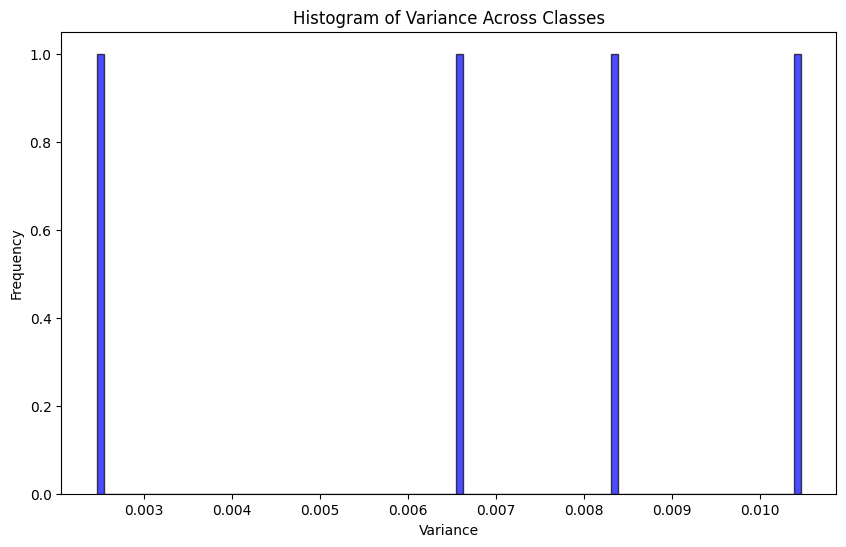

In [111]:
plt.figure(figsize=(10, 6))
plt.hist(class_variance['Variance'], bins=100, alpha=0.7, color='blue', edgecolor='black')

plt.title('Histogram of Variance Across Classes')
plt.xlabel('Variance')
plt.ylabel('Frequency')

# Show the plot
plt.show()

In [112]:
# Step 1: Identify classes with variance > X
#classes_to_exclude = class_variance[class_variance['Variance'] > 0.015]
# Step 2: Filter out these classes from data_df_clean
#print(data_df_clean.shape)
#data_df_clean = data_df_clean[~data_df_clean['temperature'].isin(classes_to_exclude)]
#data_df_clean

In [113]:
data_df['temperature'].value_counts()

temperature
temperature:mesophilic           26633
temperature:thermophilic          1849
temperature:psychrophilic         1261
temperature:hyperthermophilic      260
Name: count, dtype: int64

In [114]:
data_df['temperature'].value_counts()

temperature
temperature:mesophilic           26633
temperature:thermophilic          1849
temperature:psychrophilic         1261
temperature:hyperthermophilic      260
Name: count, dtype: int64

In [115]:
data_df_clean

,CHEBI:100147,CHEBI:10024,CHEBI:100241,CHEBI:100246,CHEBI:10057,CHEBI:102130,CHEBI:102484,CHEBI:115156,CHEBI:116278,CHEBI:11986,...,trophic_type:oligotrophy,trophic_type:organoheterotrophy,trophic_type:organotrophy,trophic_type:photoautotrophy,trophic_type:photoheterotrophy,trophic_type:photolithoautotrophy,trophic_type:photolithotrophy,trophic_type:photoorganoheterotrophy,trophic_type:phototrophy,temperature
subject,,,,,,,,,,,,,,,,,,,,,
NCBITaxon:100,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,temperature:mesophilic
NCBITaxon:100053,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,temperature:mesophilic
NCBITaxon:1000562,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,temperature:mesophilic
NCBITaxon:1000566,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,temperature:mesophilic
NCBITaxon:1001,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,temperature:mesophilic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
strain:bacdive_97,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,temperature:mesophilic
strain:bacdive_98,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,temperature:mesophilic
strain:bacdive_9804,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,temperature:mesophilic


In [116]:
file_path_1 = "../output/NCBITaxon_to_EC.tsv"

# Load the first DataFrame from the compressed TSV
EC_annot = pd.read_csv(file_path_1, sep='\t', index_col=0)#, compression='gzip')
EC_annot

,EC
NCBITaxon,
NCBITaxon:57497,EC:3.4.19.3
NCBITaxon:57497,EC:2.1.1.199
NCBITaxon:57497,EC:2.6.1.16
NCBITaxon:57497,EC:6.1.1.17
NCBITaxon:57497,EC:1.18.1.2
...,...
NCBITaxon:266265,EC:1.5.-.-
NCBITaxon:266265,EC:1.5.5.2
NCBITaxon:375451,EC:2.7.1.26


In [117]:
%%time
EC_annot_df = pd.crosstab(EC_annot.index, EC_annot['EC'])

# Display the pivot table
EC_annot_df

CPU times: user 1min 27s, sys: 2.44 s, total: 1min 29s
Wall time: 1min 32s


EC,EC:1.-.-.-,EC:1.1.-.-,EC:1.1.1.-,EC:1.1.1.1,EC:1.1.1.10,EC:1.1.1.100,EC:1.1.1.101,EC:1.1.1.102,EC:1.1.1.103,EC:1.1.1.105,...,EC:7.6.2.12,EC:7.6.2.13,EC:7.6.2.14,EC:7.6.2.15,EC:7.6.2.16,EC:7.6.2.2,EC:7.6.2.5,EC:7.6.2.7,EC:7.6.2.8,EC:7.6.2.9
row_0,,,,,,,,,,,,,,,,,,,,,
NCBITaxon:100,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
NCBITaxon:1000562,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NCBITaxon:1000565,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NCBITaxon:1000566,0,0,1,1,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
NCBITaxon:1000569,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NCBITaxon:999699,1,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NCBITaxon:999891,1,0,0,1,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
NCBITaxon:999894,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [118]:
# Select 'temperature' column from data_df_clean
data_df_clean_sub = data_df_clean[['temperature']]

# Select columns starting with 'EC:' from EC_annot_df
EC_columns = [col for col in EC_annot_df.columns if col.startswith('EC:')]
EC_annot_df_sub = EC_annot_df[EC_columns]

# Perform the join on the index (default behavior)
data_df_clean_join_EC = data_df_clean_sub.join(EC_annot_df_sub, how='inner')

# Print the remaining columns
print("Remaining columns:", data_df_clean_join_EC.columns)


Remaining columns: Index(['temperature', 'EC:1.-.-.-', 'EC:1.1.-.-', 'EC:1.1.1.-', 'EC:1.1.1.1',
       'EC:1.1.1.10', 'EC:1.1.1.100', 'EC:1.1.1.101', 'EC:1.1.1.102',
       'EC:1.1.1.103',
       ...
       'EC:7.6.2.12', 'EC:7.6.2.13', 'EC:7.6.2.14', 'EC:7.6.2.15',
       'EC:7.6.2.16', 'EC:7.6.2.2', 'EC:7.6.2.5', 'EC:7.6.2.7', 'EC:7.6.2.8',
       'EC:7.6.2.9'],
      dtype='object', length=5042)


In [119]:
%%time

file_path_1 = "../output/NCBITaxon_to_RHEA.tsv"

# Load the first DataFrame from the compressed TSV
RHEA_annot = pd.read_csv(file_path_1, sep='\t', index_col=0)#, compression='gzip')
RHEA_annot_df = pd.crosstab(RHEA_annot.index, RHEA_annot['RHEA'])
data_df_clean_join_EC = data_df_clean_join_EC.join(RHEA_annot_df, how='left', lsuffix='_trait', rsuffix='_annot')



CPU times: user 1min 19s, sys: 2.2 s, total: 1min 22s
Wall time: 1min 22s


In [120]:
data_df_clean_orig = data_df_clean.copy(deep = True)
data_df_clean = data_df_clean_join_EC.copy(deep = True)

In [121]:
# Select only numeric columns for the operation
numeric_cols = data_df_clean.select_dtypes(include=['number']).columns

# Remove columns with sum <= 1, excluding the 'temperature' column or any other non-numeric columns
dimnow = data_df_clean.shape
print(dimnow)
sum_less2 = data_df_clean[numeric_cols].sum(axis=0)
cols_to_drop = data_df_clean[numeric_cols].columns[sum_less2 <= 1]
data_df_clean = data_df_clean.drop(columns=cols_to_drop)

#Remove cols which are all 1's
numeric_cols = data_df_clean.select_dtypes(include=['number']).columns
dimnow = data_df_clean.shape
print(dimnow)
sum_less2 = data_df_clean[numeric_cols].sum(axis=0)
cols_to_drop = data_df_clean[numeric_cols].columns[sum_less2 == dimnow[1]]
data_df_clean = data_df_clean.drop(columns=cols_to_drop)


# remove rows with sum <= 1, ensuring to only sum over the updated numeric columns
numeric_cols = data_df_clean.select_dtypes(include=['number']).columns
dimnow = data_df_clean.shape
print(dimnow)
sum_less2_row = data_df_clean[numeric_cols].sum(axis=1)
rows_to_drop = data_df_clean.index[sum_less2_row <= 1]
data_df_clean = data_df_clean.drop(index=rows_to_drop)

#Remove rows which are all 1's
numeric_cols = data_df_clean.select_dtypes(include=['number']).columns
dimnow = data_df_clean.shape
print(dimnow)
sum_less2_row = data_df_clean[numeric_cols].sum(axis=1)
#print(sum_less2_row[sum_less2_row == dimnow[0]])
rows_to_drop = data_df_clean.index[sum_less2_row == dimnow[0]]
#print(rows_to_drop)
data_df_clean = data_df_clean.drop(index=rows_to_drop)
print(dimnow)

data_df_clean

(8077, 10266)
(8077, 6204)
(8077, 6204)
(8040, 6204)
(8040, 6204)


,temperature,EC:1.-.-.-,EC:1.1.-.-,EC:1.1.1.-,EC:1.1.1.1,EC:1.1.1.10,EC:1.1.1.100,EC:1.1.1.102,EC:1.1.1.103,EC:1.1.1.105,...,RHEA:79087,RHEA:79091,RHEA:79099,RHEA:79103,RHEA:79131,RHEA:79135,RHEA:79139,RHEA:79143,RHEA:79487,RHEA:79491
NCBITaxon:100,temperature:mesophilic,1,0,0,0,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
NCBITaxon:1000562,temperature:mesophilic,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
NCBITaxon:1000566,temperature:mesophilic,0,0,1,1,0,1,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
NCBITaxon:1001240,temperature:psychrophilic,1,0,1,1,0,1,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
NCBITaxon:1002367,temperature:mesophilic,0,0,0,0,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NCBITaxon:999429,temperature:mesophilic,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
NCBITaxon:999430,temperature:mesophilic,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
NCBITaxon:999552,temperature:psychrophilic,0,0,0,1,0,1,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
NCBITaxon:999894,temperature:thermophilic,0,0,0,0,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [122]:
patterns = {}
columns_to_drop = []
retention_map = {}

# Iterate over columns
for col in data_df_clean.columns:
    pattern = tuple(data_df_clean[col])
    if pattern not in patterns:
        patterns[pattern] = col
        retention_map[col] = []  # Initialize the list of dropped columns for this pattern
    else:
        # Add the current column to the drop list and map it to the retained column
        columns_to_drop.append(col)
        retention_map[patterns[pattern]].append(col)

# Drop duplicate columns
data_df_clean = data_df_clean.drop(columns=columns_to_drop)

# Prepare to write the mapping to a file
retention_df = pd.DataFrame(
    [(retained, ','.join(duplicates)) for retained, duplicates in retention_map.items() if duplicates],
    columns=['Retained Column', 'Deleted Columns']
)

# Write to CSV file
retention_df.to_csv(f'retention_df__{modellabel}.csv', index=False)

# Display what was saved to file
retention_df

,Retained Column,Deleted Columns
0,EC:1.13.11.81,EC:3.1.3.100
1,EC:1.13.11.91,"EC:1.8.5.9,EC:2.5.1.144"
2,EC:1.14.13.18,EC:1.2.1.63
3,EC:1.14.15.20,EC:2.3.1.75
4,EC:1.3.7.5,EC:2.1.1.329
5,EC:2.1.1.294,EC:2.7.1.181
6,EC:2.3.1.158,EC:2.4.1.214
7,EC:2.3.1.87,EC:3.6.3.46
8,EC:2.3.2.1,EC:2.4.1.147
9,EC:2.4.1.132,EC:2.4.1.257


In [123]:
data_df_clean['temperature'].value_counts()

temperature
temperature:mesophilic           7193
temperature:thermophilic          452
temperature:psychrophilic         317
temperature:hyperthermophilic      78
Name: count, dtype: int64

In [124]:

data_df_clean = data_df_clean.groupby('temperature').filter(lambda x : len(x)>39)

data_df_clean

,temperature,EC:1.-.-.-,EC:1.1.-.-,EC:1.1.1.-,EC:1.1.1.1,EC:1.1.1.10,EC:1.1.1.100,EC:1.1.1.102,EC:1.1.1.103,EC:1.1.1.105,...,RHEA:79087,RHEA:79091,RHEA:79099,RHEA:79103,RHEA:79131,RHEA:79135,RHEA:79139,RHEA:79143,RHEA:79487,RHEA:79491
NCBITaxon:100,temperature:mesophilic,1,0,0,0,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
NCBITaxon:1000562,temperature:mesophilic,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
NCBITaxon:1000566,temperature:mesophilic,0,0,1,1,0,1,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
NCBITaxon:1001240,temperature:psychrophilic,1,0,1,1,0,1,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
NCBITaxon:1002367,temperature:mesophilic,0,0,0,0,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NCBITaxon:999429,temperature:mesophilic,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
NCBITaxon:999430,temperature:mesophilic,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
NCBITaxon:999552,temperature:psychrophilic,0,0,0,1,0,1,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
NCBITaxon:999894,temperature:thermophilic,0,0,0,0,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [125]:
file_path = f'taxa_to__data_df_clean_{modellabel}.tsv.gz'
data_df_clean.to_csv(file_path, sep='\t', index=True, header=True, compression='gzip')


In [126]:
cols_to_drop = data_df_clean.columns[data_df_clean.columns.str.startswith('temperature')]

X = data_df_clean.drop(cols_to_drop, axis=1)
y = data_df_clean['temperature'] 

In [127]:
'''
# Step 1: Create a DataFrame with 'id' and 'name'
mapping_df = data_nodes[['id', 'name']].copy()

# Step 2: Generate a count for each occurrence of a name to handle duplicates
mapping_df['name_count'] = mapping_df.groupby('name').cumcount()

# Step 3: Extract prefix from 'id' (e.g., 'CHEBI:', 'GO:', etc.)
mapping_df['prefix'] = mapping_df['id'].str.extract(r'^([^:]+:)')[0]

# Step 4: Create unique names by appending a suffix to duplicates and prepending prefix
def create_name_unique(row):
    prefix = row['prefix']
    name = row['name']
    name_count = row['name_count']
    
    # Check for NaN values in 'prefix' or 'name'
    if pd.isna(prefix) or pd.isna(name):
        return None  # Return None if 'prefix' or 'name' is NaN
    else:
        # Create the unique name
        if name_count > 0:
            return f"{prefix}{name}_{name_count}"
        else:
            return f"{prefix}{name}"

mapping_df['name_unique'] = mapping_df.apply(create_name_unique, axis=1)

# Step 5: Exclude mappings where 'name_unique' is None or contains 'nan'
valid_mapping_df = mapping_df.dropna(subset=['name_unique'])
valid_mapping_df = valid_mapping_df[~valid_mapping_df['name_unique'].str.contains('nan', na=False)]

# Step 6: Create the mapping dictionary from 'id' to 'name_unique'
id_to_unique_name = valid_mapping_df.set_index('id')['name_unique'].to_dict()

# Step 7: Rename the columns in X using the unique mapping
X.rename(columns=id_to_unique_name, inplace=True)
'''


'\n# Step 1: Create a DataFrame with \'id\' and \'name\'\nmapping_df = data_nodes[[\'id\', \'name\']].copy()\n\n# Step 2: Generate a count for each occurrence of a name to handle duplicates\nmapping_df[\'name_count\'] = mapping_df.groupby(\'name\').cumcount()\n\n# Step 3: Extract prefix from \'id\' (e.g., \'CHEBI:\', \'GO:\', etc.)\nmapping_df[\'prefix\'] = mapping_df[\'id\'].str.extract(r\'^([^:]+:)\')[0]\n\n# Step 4: Create unique names by appending a suffix to duplicates and prepending prefix\ndef create_name_unique(row):\n    prefix = row[\'prefix\']\n    name = row[\'name\']\n    name_count = row[\'name_count\']\n    \n    # Check for NaN values in \'prefix\' or \'name\'\n    if pd.isna(prefix) or pd.isna(name):\n        return None  # Return None if \'prefix\' or \'name\' is NaN\n    else:\n        # Create the unique name\n        if name_count > 0:\n            return f"{prefix}{name}_{name_count}"\n        else:\n            return f"{prefix}{name}"\n\nmapping_df[\'name_unique

In [128]:
X.columns

Index(['EC:1.-.-.-', 'EC:1.1.-.-', 'EC:1.1.1.-', 'EC:1.1.1.1', 'EC:1.1.1.10',
       'EC:1.1.1.100', 'EC:1.1.1.102', 'EC:1.1.1.103', 'EC:1.1.1.105',
       'EC:1.1.1.107',
       ...
       'RHEA:79087', 'RHEA:79091', 'RHEA:79099', 'RHEA:79103', 'RHEA:79131',
       'RHEA:79135', 'RHEA:79139', 'RHEA:79143', 'RHEA:79487', 'RHEA:79491'],
      dtype='object', length=6177)

In [129]:
len(set(data_df_clean['temperature']))

4

In [130]:
len(set(data_df['temperature']))

4

In [131]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=RANDOM_SEED)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.33, stratify=y_temp, random_state=RANDOM_SEED)

train_data = Pool(data=X_train, label=y_train, cat_features=[])
val_data = Pool(data=X_val, label=y_val, cat_features=[])
test_data = Pool(data=X_test, label=y_test, cat_features=[])

In [132]:
#6908
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(5628, 6177)
(1616, 6177)
(796, 6177)


In [133]:
X_train.columns[X_train.columns.str.contains('temperature')]

Index([], dtype='object')

In [134]:
cv_params = {
    'iterations': 200000,
    'depth': 4,
    'learning_rate': 0.05,
    'l2_leaf_reg': 4,
    'bagging_temperature': 1,
    'random_strength': 6,
    'loss_function': 'MultiClass',
    'random_seed': RANDOM_SEED,
    'verbose': 100,
    'early_stopping_rounds': 50,
    'use_best_model': True
}

In [135]:
%%time

model = CatBoostClassifier(**cv_params)

model.fit(train_data, 
          eval_set=val_data,
          early_stopping_rounds=50 
         )#, plot=True)

0:	learn: 1.2788785	test: 1.2786700	best: 1.2786700 (0)	total: 85.7ms	remaining: 4h 45m 49s
100:	learn: 0.3194135	test: 0.3259343	best: 0.3259343 (100)	total: 5.74s	remaining: 3h 9m 17s
200:	learn: 0.2587675	test: 0.2780095	best: 0.2780095 (200)	total: 11.5s	remaining: 3h 11m 20s
300:	learn: 0.2317812	test: 0.2631215	best: 0.2631215 (300)	total: 17.4s	remaining: 3h 12m 15s
400:	learn: 0.2167197	test: 0.2558457	best: 0.2558457 (400)	total: 23s	remaining: 3h 11m 7s
500:	learn: 0.2065666	test: 0.2507937	best: 0.2507937 (500)	total: 28.7s	remaining: 3h 10m 17s
600:	learn: 0.1989023	test: 0.2477249	best: 0.2477232 (599)	total: 34.2s	remaining: 3h 9m 20s
700:	learn: 0.1930540	test: 0.2458150	best: 0.2458115 (699)	total: 40.2s	remaining: 3h 10m 21s
800:	learn: 0.1868851	test: 0.2436350	best: 0.2436203 (799)	total: 46s	remaining: 3h 10m 39s
900:	learn: 0.1822470	test: 0.2419808	best: 0.2419687 (891)	total: 51.8s	remaining: 3h 10m 54s
1000:	learn: 0.1777385	test: 0.2403505	best: 0.2403505 (1000

In [136]:
# Predict on test data
y_pred = model.predict(test_data)
y_pred_proba = model.predict_proba(test_data)[:,1]  # Probabilities for the positive class

# Print metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred))  # Adding balanced accuracy
print("\nClassification Report:\n", classification_report(y_test, y_pred))
#print("AUC-ROC:", roc_auc_score(y_test, y_pred_proba))

Accuracy: 0.928391959798995
Balanced Accuracy: 0.6132236418186943

Classification Report:
                                precision    recall  f1-score   support

temperature:hyperthermophilic       1.00      0.88      0.93         8
       temperature:mesophilic       0.93      0.99      0.96       712
    temperature:psychrophilic       0.83      0.16      0.27        31
     temperature:thermophilic       0.83      0.42      0.56        45

                     accuracy                           0.93       796
                    macro avg       0.90      0.61      0.68       796
                 weighted avg       0.92      0.93      0.91       796



In [137]:

# Save the model to a file
model.save_model(f'catboost_model_kg_microbe_train_taxa_to_{formatted_date}__{modellabel}.cbm')


#loaded_model = CatBoostClassifier()  # or CatBoostRegressor() depending on your model type
#loaded_model.load_model('catboost_model.cbm')

In [138]:
# Generate classification report
report = classification_report(y_test, y_pred, output_dict=True)

# Convert the classification report to a DataFrame
report_df = pd.DataFrame(report).transpose()

# Filter rows where both precision and recall are greater than 0.9
# Note: Precision and recall are not defined for the 'accuracy' row, so we exclude it from the filter
report_filtered_df = report_df[(report_df['precision'] > 0.9) & (report_df['recall'] > 0.9)]# & (report_df.index != 'accuracy')]

# Print out the filtered rows
report_filtered_df

,precision,recall,f1-score,support
temperature:mesophilic,0.931579,0.994382,0.961957,712.000000
accuracy,0.928392,0.928392,0.928392,0.928392
weighted avg,0.922477,0.928392,0.911941,796.000000


In [139]:
report_df[(report_df['precision'] > 0.8) & (report_df['recall'] > 0.5)]

,precision,recall,f1-score,support
temperature:hyperthermophilic,1.000000,0.875000,0.933333,8.000000
temperature:mesophilic,0.931579,0.994382,0.961957,712.000000
accuracy,0.928392,0.928392,0.928392,0.928392
macro avg,0.897750,0.613224,0.681096,796.000000
weighted avg,0.922477,0.928392,0.911941,796.000000


In [140]:
report_df[(report_df['precision'] == 0) & (report_df['recall'] == 0)].index

Index([], dtype='object')

In [141]:
report_df[(report_df['precision'] < 0.5)].index

Index([], dtype='object')

In [142]:
report_filtered_80_df = report_df[(report_df['precision'] > 0.8) & (report_df['recall'] > 0.5)]# & (report_df.index != 'accuracy')]

# Print out the filtered rows
print(report_filtered_80_df)

                               precision    recall  f1-score     support
temperature:hyperthermophilic   1.000000  0.875000  0.933333    8.000000
temperature:mesophilic          0.931579  0.994382  0.961957  712.000000
accuracy                        0.928392  0.928392  0.928392    0.928392
macro avg                       0.897750  0.613224  0.681096  796.000000
weighted avg                    0.922477  0.928392  0.911941  796.000000


In [143]:
# Predict on train data
y_pred_train = model.predict(train_data)
y_pred_proba_train = model.predict_proba(train_data)[:,1]  # Probabilities for the positive class

# Print metrics                                                                                                                        
print("Accuracy:", accuracy_score(y_train, y_pred_train))
print("Balanced Accuracy:", balanced_accuracy_score(y_train, y_pred_train))  # Adding balanced accuracy
print("\nClassification Report:\n", classification_report(y_train, y_pred_train))
#print("AUC-ROC:", roc_auc_score(y_test, y_pred_proba))

Accuracy: 0.9481165600568585
Balanced Accuracy: 0.706375586349786

Classification Report:
                                precision    recall  f1-score   support

temperature:hyperthermophilic       0.91      0.93      0.92        55
       temperature:mesophilic       0.95      1.00      0.97      5035
    temperature:psychrophilic       0.98      0.27      0.42       222
     temperature:thermophilic       0.94      0.63      0.76       316

                     accuracy                           0.95      5628
                    macro avg       0.95      0.71      0.77      5628
                 weighted avg       0.95      0.95      0.94      5628



In [144]:
# Initialize the CalibratedClassifierCV with isotonic regression
calibrated_model = CalibratedClassifierCV(estimator=model, method='isotonic', cv='prefit')

# Calibrate the model on the validation data
calibrated_model.fit(X_val, y_val)

# Predict calibrated probabilities on the test set
test_pred_proba = calibrated_model.predict_proba(X_test)

# Convert y_test to one-hot encoded format
y_test_onehot = label_binarize(y_test, classes=model.classes_)

# Calculate Brier score for each class and average them
brier_scores = [
    brier_score_loss(y_test_onehot[:, i], test_pred_proba[:, i])
    for i in range(len(model.classes_))
]
average_brier_score = np.mean(brier_scores)

# Calculate log loss
logloss = log_loss(y_test, test_pred_proba)

print(f'Average Brier score: {average_brier_score}')
print(f'Log loss: {logloss}')

Average Brier score: 0.029391921685111358
Log loss: 0.317691652735378


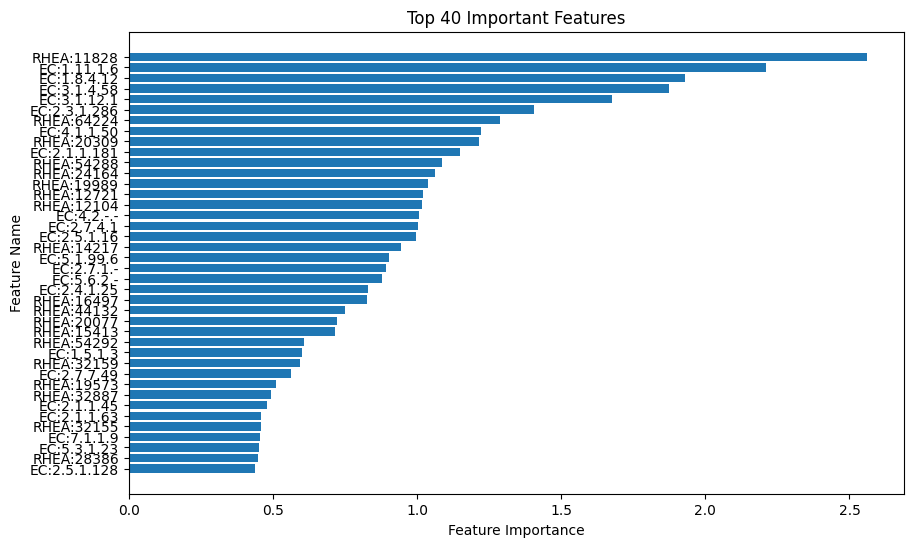

In [145]:
feature_importances = model.get_feature_importance()

# Assuming your feature names are stored in a list 'feature_names'
feature_names = X_test.columns.values#['feature1', 'feature2', ..., 'featureN']

# Create a list of (feature_name, importance) tuples
feature_importance_tuples = [(name, importance) for name, importance in zip(feature_names, feature_importances)]

# Sort the feature importances in descending order and take the top 10
topn = 40
top_100_features = sorted(feature_importance_tuples, key=lambda x: x[1], reverse=True)[:topn]

# Separate the feature names and their importances
top_features, top_importances = zip(*top_100_features)

# Creating the bar plot
plt.figure(figsize=(10, 6))
plt.barh(range(len(top_importances)), top_importances, align='center')
plt.yticks(range(len(top_importances)), top_features)
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Top '+str(topn)+' Important Features')

figure_name = f"top_"+str(topn)+"_features_catboost__{modellabel}.pdf"
# Save the figure as a PDF
plt.savefig(f"{figure_name}.pdf", format='pdf', bbox_inches='tight')

# Save the figure as a PNG
plt.savefig(f"{figure_name}.png", format='png', bbox_inches='tight')

plt.show()

In [146]:
# Calculate SHAP values
shap_values = model.get_feature_importance(train_data, type='ShapValues')

# Debugging information
print(f"SHAP values shape: {shap_values.shape}")
print(f"SHAP values sample: {shap_values[:1]}")

# The SHAP values array has the shape (num_samples, num_features, num_classes + 1)
num_classes = len(model.classes_)
feature_names = model.feature_names_
num_features = len(feature_names)

print(f"Number of classes: {num_classes}")
print(f"Number of features: {num_features}")

# Initialize a dictionary to hold the SHAP values per feature per class
shap_dict = {feature: [0] * num_classes for feature in feature_names}

# Aggregate SHAP values for each feature per class
for class_index in range(num_classes):
    shap_class_values = shap_values[:, class_index, :-1]  # Exclude the last column (base value)
    print(f"SHAP values for class {class_index} shape: {shap_class_values.shape}")
    for feature_index, feature in enumerate(feature_names):
        mean_shap_value = shap_class_values[:, feature_index].mean()
        if mean_shap_value != 0:
            shap_dict[feature][class_index] = mean_shap_value

# Convert dictionary to DataFrame
shap_df = pd.DataFrame(shap_dict, index=model.classes_)


# Save the DataFrame to a file
shap_df.to_csv(f'shap_values_per_class_{modellabel}.csv')

SHAP values shape: (5628, 4, 6178)
SHAP values sample: [[[ 1.72558300e-03  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   -8.71353314e-06 -4.54337239e+00]
  [ 2.98825524e-03  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    1.22733415e-05  4.21147839e+00]
  [-3.43509324e-03  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   -2.43511274e-06  3.28505829e-01]
  [-1.27874500e-03  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   -1.12469564e-06  3.38817682e-03]]]
Number of classes: 4
Number of features: 6177
SHAP values for class 0 shape: (5628, 6177)
SHAP values for class 1 shape: (5628, 6177)
SHAP values for class 2 shape: (5628, 6177)
SHAP values for class 3 shape: (5628, 6177)


In [147]:
X_train.shape

(5628, 6177)

In [148]:

explainer = shap.TreeExplainer(model)
# Assuming explainer and X_train_final are already defined
shap_values_all = explainer.shap_values(X_train)


In [149]:
print(f"{shap_values_all.shape}")

(5628, 6177, 4)


In [150]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap

mpl.rcParams['pdf.fonttype'] = 42

# Get the class labels
class_labels = model.classes_
class_labels = [str(label).replace(':', '_') for label in class_labels]

# Print the class labels to verify
print(f"Class labels: {class_labels}")

# Iterate over each class to create separate SHAP summary plots and save feature importances
for i, class_label in enumerate(class_labels):
    # Select SHAP values for the current class
    shap_values_class = shap_values_all[:, :, i]
    
    print(f"X_train.shape: {X_train.shape}")
    print(f"shap_values_class.shape: {shap_values_class.shape}")

    # Ensure the shapes match before proceeding
    assert X_train.shape == shap_values_class.shape, "Shapes of X_train and shap_values_class do not match!"

    # Compute mean absolute SHAP value per feature
    mean_abs_shap_values = np.abs(shap_values_class).mean(axis=0)  # shape: (n_features,)

    # Assuming X_train is a DataFrame, get the feature names
    feature_names = X_train.columns

    # Create a DataFrame
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'MeanAbsSHAPValue': mean_abs_shap_values
    })

    # Sort the DataFrame by MeanAbsSHAPValue descending
    importance_df = importance_df.sort_values(by='MeanAbsSHAPValue', ascending=False)

    # Save the DataFrame to a CSV file
    importance_df.to_csv(f'shap_feature_importance_class_{class_label}_{modellabel}.tsv', sep="\t", index=False)

    # Create a figure with a larger size to accommodate y-axis labels
    plt.figure(figsize=(12, 8))  # Adjust the figure size as needed

    # Create the SHAP summary plot with a specific color map and top 40 features
    shap.summary_plot(
        shap_values_class,
        X_train,
        max_display=40,
        cmap=plt.get_cmap("coolwarm"),
        show=False,
        plot_size=(12, 8)  # Adjust the plot size within the figure
    )

    # Adjust the layout to ensure y-axis labels are not cut off
    plt.tight_layout()

    # Add title
    plt.title(f"SHAP Summary Plot for Class: {class_label}")

    # Save the plot to PDF and PNG files with tight bounding box
    plt.savefig(f"shap_summary_class_{class_label}_{modellabel}.pdf", format='pdf', bbox_inches='tight')
    plt.savefig(f"shap_summary_class_{class_label}_{modellabel}.png", format='png', bbox_inches='tight')

    # Clear the current plot to prepare for the next one
    plt.clf()


Class labels: ['temperature_hyperthermophilic', 'temperature_mesophilic', 'temperature_psychrophilic', 'temperature_thermophilic']
X_train.shape: (5628, 6177)
shap_values_class.shape: (5628, 6177)
X_train.shape: (5628, 6177)
shap_values_class.shape: (5628, 6177)
X_train.shape: (5628, 6177)
shap_values_class.shape: (5628, 6177)
X_train.shape: (5628, 6177)
shap_values_class.shape: (5628, 6177)


<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

In [151]:
print(f"{X_train.shape} {shap_values.shape}")

(5628, 6177) (5628, 4, 6178)


In [152]:
import pandas as pd

# Assuming feature_importance_tuples is already defined
feature_importance_tuples = [(name, importance) for name, importance in zip(feature_names, feature_importances)]

# Create a DataFrame from the tuples
df_feature_importance = pd.DataFrame(feature_importance_tuples, columns=['Feature', 'Importance'])

# Save the DataFrame to a CSV file
df_feature_importance.to_csv(f'feature_importance_{modellabel}.csv', index=False)

print("Feature importance DataFrame saved to 'feature_importance_FINAL.csv'")


Feature importance DataFrame saved to 'feature_importance_FINAL.csv'


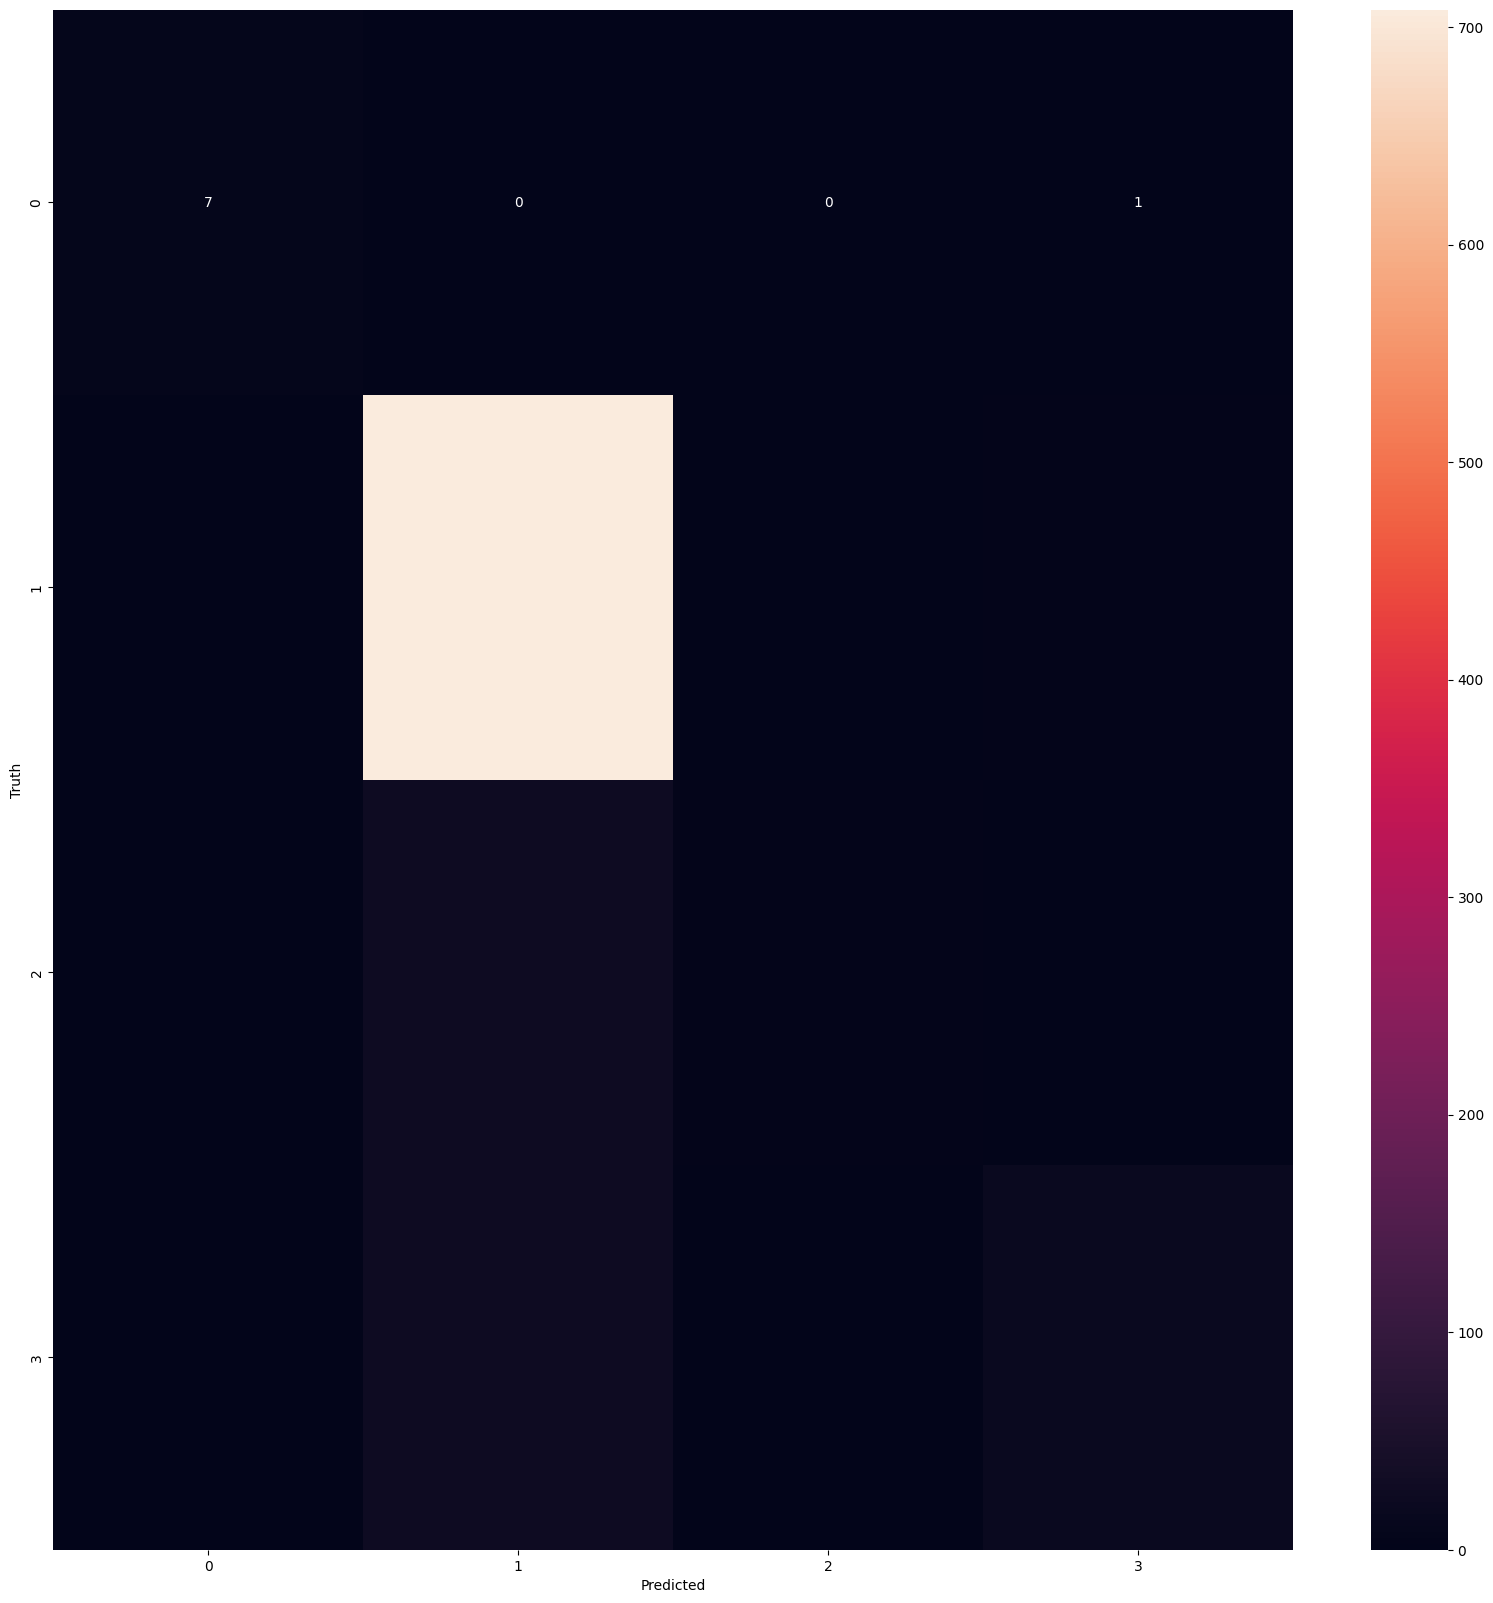

In [153]:
# True labels are assumed to be in y_test
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(20,20))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.savefig(f'confusion_'+formatted_date+'__{modellabel}.pdf', format='pdf')
plt.show()